In [206]:
import pandas as pd
import numpy as np
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import time
import matplotlib.pyplot as plt
import math
import copy
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor
from tensorflow.keras.layers import Input
from sklearn.preprocessing import StandardScaler
from keras.layers import Dropout

In [207]:
# HIPERPARÂMETROS:
start_date = '2014-08-21'
W = 250  # Lembrando que o tamanho do treinamento será W - w
w = 14  

In [208]:
# Criptomoedas que vamos escolher para nosso portifólio
cryptos = [
    'BTC-USD', 'LTC-USD'
]

In [209]:
## Função para calcular o retorno logarítmico
def log_return(series):
    return np.log(series['Close'] / series['Open'])

In [210]:
def fracdiff_weights(d, size):
    # Inicializa o vetor de pesos
    we = [1.0]
    for k in range(1, size):
        we.append(-we[-1] * ((d - k + 1)) / k)
    return np.array(we[::-1])  # Inverte a ordem dos pesos

In [211]:
data = {}
for crypto in cryptos:
    # Baixar dados e calcular retorno logarítmico
    df = yf.download(crypto, start=start_date, end=pd.to_datetime("today").strftime("%Y-%m-%d"), interval='1d')
    df['Return'] = log_return(df)

    # Construir DataFrame final, pegando o retorno do dia anterior e o atual
    df_final = pd.DataFrame({
        #'Volume': df['Volume'],
        'Price': df['Open'],
        'Crypto_Return_Today': df['Return']
    }).dropna()

    data[crypto] = df_final

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [212]:
aux = yf.download('BTC-USD', start=start_date, end=pd.to_datetime("today").strftime("%Y-%m-%d"), interval='1d')
aux['Return'] = aux['Open']
aux = pd.DataFrame({'BTC-Price': aux['Return']})

for crypto in cryptos:
    if crypto != 'BTC-USD':
        data[crypto] = pd.merge(aux, data[crypto],  left_index=True, right_index=True, how='outer').dropna()

[*********************100%%**********************]  1 of 1 completed


In [ ]:
aux = yf.download('LTC-USD', start=start_date, end=pd.to_datetime("today").strftime("%Y-%m-%d"), interval='1d')
aux['Return'] = aux['Open']
aux = pd.DataFrame({'LTC-Price': aux['Return']})

data['BTC-USD'] = pd.merge(aux, data['BTC-USD'],  left_index=True, right_index=True, how='outer').dropna()

[*********************100%%**********************]  1 of 1 completed


In [213]:
data['BTC-USD']

,Price,Crypto_Return_Today
Date,,
2014-09-17,465.864014,-0.018480
2014-09-18,456.859985,-0.073606
2014-09-19,424.102997,-0.071607
2014-09-20,394.673004,0.035423
2014-09-21,408.084991,-0.022963
...,...,...
2024-11-05,67811.171875,0.022577
2024-11-06,69358.500000,0.086684
2024-11-07,75637.085938,0.003534


In [214]:
from statsmodels.tsa.stattools import adfuller

window_size = 50  # Ajuste para o tamanho desejado do histórico
def fracdiff(series, weights):
    diff_series = []
    for i in range(window_size, len(series)):
        window = series[i - window_size:i]
        diff_value = np.dot(weights, window)
        diff_series.append(diff_value)
    return pd.Series(diff_series, index=series.index[window_size:])

In [215]:
def find_optimal_d(series, window_size=10, threshold=0.01, d_step=0.01, max_d=1.0):
    d = 0.2  # Inicie com d = 0.2
    while d <= max_d:
        # Calcula os pesos e a série diferenciada fracionariamente
        weights = fracdiff_weights(d, window_size)
        diff_series = fracdiff(series, weights).dropna()

        # Executa o teste ADF
        adf_result = adfuller(diff_series)
        p_value = adf_result[1]

        # Verifica se o p_value é menor que o threshold
        if p_value < threshold:
            return d, p_value  # Retorna o d encontrado e o p_value correspondente

        # Aumenta d pelo passo definido
        d += d_step

    # Caso não encontre um d adequado
    return None, None

In [189]:
optimal_d = {}
p_value = {}
for crypto in cryptos:
    df = data[crypto].copy()
    close_prices = df['Price'].loc['2019-06-30':]
    optimal_d[crypto], p_value[crypto] = find_optimal_d(close_prices, window_size=50, threshold=0.01, d_step=0.01, max_d=1.0)
    print(crypto, optimal_d[crypto], p_value[crypto])


BTC-USD 0.6200000000000003 0.009037908244027025
LTC-USD 0.3900000000000002 0.008494487368962314


In [ ]:
window_size = 50
for crypto in cryptos:
    d = optimal_d[crypto]
    weights = fracdiff_weights(d, window_size)
    data[crypto]['frac_feat_1'] = fracdiff(data[crypto]['Price'], weights).shift(-1)

    columns = list(data['BTC-USD'].columns)
    columns[-2], columns[-1] = columns[-1], columns[-2]
    data[crypto] = data[crypto][columns]  

In [243]:
data['BTC-USD'].dropna()

,Price,frac_feat_1,Crypto_Return_Today
Date,,,
2014-11-06,339.458008,18.386308,0.028552
2014-11-07,349.817993,23.407566,-0.021390
2014-11-08,342.153992,8.505984,0.009697
2014-11-09,345.376007,14.999447,0.050496
2014-11-10,362.265015,30.158388,0.012779
...,...,...,...
2024-11-04,68742.132812,2161.366915,-0.013630
2024-11-05,67811.171875,1626.734401,0.022577
2024-11-06,69358.500000,3833.443702,0.086684


ADF t-statistic para série fracionariamente diferenciada: -3.4807857830566857
ADF p-value para série fracionariamente diferenciada: 0.008494487368962314


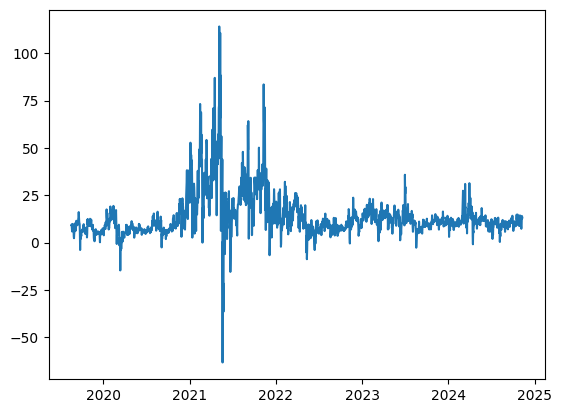

In [197]:
#adf_result = adfuller(close_prices_frac_diff.dropna().loc['2019-06-30':])  # Remova valores NA, se houver
adf_result = adfuller(close_prices_frac_diff.dropna()) 
# Obtenha o t-statistic e o p-value
t_statistic = adf_result[0]
p_value = adf_result[1]

print("ADF t-statistic para série fracionariamente diferenciada:", t_statistic)
print("ADF p-value para série fracionariamente diferenciada:", p_value)


#plt.plot(pd.DataFrame(close_prices_frac_diff.loc['2019-06-30':]))
plt.plot(pd.DataFrame(close_prices_frac_diff))

In [ ]:
adf_result = adfuller(close_prices.dropna())  # Remova valores NA, se houver

# Obtenha o t-statistic e o p-value
t_statistic = adf_result[0]
p_value = adf_result[1]

print("ADF t-statistic para série:", t_statistic)
print("ADF p-value para série:", p_value)

plt.plot(pd.DataFrame(close_prices))

In [85]:
data_complete = {}
for crypto in cryptos:
    # Baixar dados e calcular retorno logarítmico
    df = yf.download(crypto, start=start_date, end=pd.to_datetime("today").strftime("%Y-%m-%d"), interval='1d')
    df['Return'] = log_return(df)

    # Construir DataFrame final, pegando o retorno do dia anterior e o atual
    df_final = pd.DataFrame({
        #'Volume': df['Volume'],
        'Crypto_Return_Today': df['Return']
    }).dropna()

    # Adicionar a coluna 'exp_value' com valores NaN
    df_final['exp_value'] = np.nan

    # Armazenar no dicionário
    data_complete[crypto] = df_final

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [86]:
print(len(data_complete['LTC-USD']))
data_complete['LTC-USD']

3707


,Crypto_Return_Today,exp_value
Date,,
2014-09-17,-0.005390,NaN
2014-09-18,-0.078024,NaN
2014-09-19,-0.079802,NaN
2014-09-20,-0.009926,NaN
2014-09-21,-0.004031,NaN
...,...,...
2024-11-05,-0.000798,NaN
2024-11-06,0.081865,NaN
2024-11-07,0.006597,NaN


In [10]:
# Criando a função First Transformation, que recebe uma tabela contendo os retornos de todos os dias dos ultimos X anos e retorno um vetor, que cada elemento
# é uma tabela do retorno de W+1 dias.
def FirstTransform(df, W):
    vet = []
    Linhas, Colunas = df.shape
    for i in range(Linhas, W+1, -1):
        vet.append(df.iloc[(i-W-1):i])
    return vet

In [11]:
# Aqui eu perco W+1 dias do meu dataset
for crypto in cryptos:
    data[crypto] = FirstTransform(data[crypto], W)

In [12]:
print(len(data['LTC-USD']))
data['LTC-USD'][0]

3448


,BTC-Return,Crypto_Return_Today
Date,,
2024-02-25,0.003253,-0.004336
2024-02-26,0.052563,0.026062
2024-02-27,0.045992,0.028612
2024-02-28,0.090945,0.007628
2024-02-29,-0.021033,0.069407
...,...,...
2024-10-28,0.028807,-0.005068
2024-10-29,0.039414,0.045062
2024-10-30,-0.005182,-0.029316


## 2.2 Separar em treinamento e teste - Permitir Bagging

In [13]:
test_target = {}
for crypto in cryptos:
    row = []
    for i in range(len(data[crypto])):
        row.append((pd.DataFrame(data[crypto][i].iloc[-1])).T)
        data[crypto][i] = data[crypto][i].drop(data[crypto][i].index[-1])
    test_target[crypto] = row

In [14]:
data['LTC-USD'][0], test_target['LTC-USD'][0]['Crypto_Return_Today']

(            BTC-Return  Crypto_Return_Today
 Date                                       
 2024-02-25    0.003253            -0.004336
 2024-02-26    0.052563             0.026062
 2024-02-27    0.045992             0.028612
 2024-02-28    0.090945             0.007628
 2024-02-29   -0.021033             0.069407
 ...                ...                  ...
 2024-10-27    0.013424             0.038447
 2024-10-28    0.028807            -0.005068
 2024-10-29    0.039414             0.045062
 2024-10-30   -0.005182            -0.029316
 2024-10-31   -0.029744            -0.037382
 
 [250 rows x 2 columns],
 2024-11-01    0.014388
 Name: Crypto_Return_Today, dtype: float64)

## 2.3 Bagging

In [15]:
# Definindo uma função bagging, que recebe um dataframe e retorna um vetor de dataframes.
def Bagging(df, n, gamma):
    df_bagged = []
    for i in range(gamma):
        aux = df.sample(n = n, random_state = i)
        aux = aux.sort_index()
        df_bagged.append(aux)
    return df_bagged

# 3. Machine Learning

* vamos peimeiro fazer do modo 1 para todos os dias
* depois aplicar para os ultimos 290 dias o modo 2 (contém bagging e purge K-Fold-CV)

## 3.1 Função do Modelo


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau


def create_model(a, b):
    model = Sequential([
        Input(shape=(a, b)),
        LSTM(units=64, return_sequences=True, kernel_regularizer=l2(0.002)),
        Dropout(0.3),
        BatchNormalization(),
        LSTM(units=32, return_sequences=False),
        Dropout(0.3),
        Dense(units=1)
    ])
    optimizer = RMSprop(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model


In [ ]:
# Função do modelo LSTM
def Model(df, time_step, features, model=None):
    # Normalizando o dataframe
    #scaler = StandardScaler()
    #df_scaled = scaler.fit_transform(df)
    #df_array = np.array(df_scaled)
    df_array = np.array(df)

    # Transformando no formato LSTM
    X_lstm = []
    y_lstm = []
    for i in range(time_step, len(df_array)):
        X_lstm.append(df_array[i-time_step:i, :])  # Pega 'timesteps' linhas anteriores
        y_lstm.append(df_array[i])  # Alvo é o valor do dia seguinte
    X_lstm = np.array(X_lstm)
    y_lstm = np.array(y_lstm)

    # Separar o X_train (todos exceto o último elemento)
    X_train = X_lstm[:-1]
    y_train = y_lstm[:-1]
    y_train = pd.DataFrame(y_train)[features - 1].to_numpy()
    y_train = y_train.reshape((len(y_train), 1))
    y_train.shape

    # X_test e y_test
    X_test = X_lstm[-1:]
    y_test = y_lstm[-1:]
    y_test = y_lstm[-1:]
    y_test = pd.DataFrame(y_test)[features - 1].to_numpy()
    y_test = y_test.reshape((len(y_test), 1))

    # Treinar o modelo específico para a criptomoeda

    # Arquitetura 1:
    #reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=1e-6, verbose=0)
    #model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=0, callbacks=[reduce_lr])


    # Arquitetura 2:
    model.fit(X_train, y_train, epochs=150, verbose=0)
    # Fazer a previsão
    y_hat_scaled = model.predict(X_test)


    return y_hat_scaled

##  3.2 Treinamento com Paralelismo e Geração dos Expected Values

In [18]:
def Add(y_hat, data_complete, ind, crypto):
    data_complete[crypto].at[ind, 'exp_value'] = y_hat

In [19]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Usando GPU:", physical_devices[0])
else:
    print("Usando CPU")

Usando CPU


In [20]:
for crypto in cryptos:
    print(len(data[crypto]))
len(data['LTC-USD'][0])

3448
3448


250

In [ ]:
test_target['LTC-USD'][2550]
test_target['LTC-USD'][1837]

,BTC-Return,Crypto_Return_Today
2018-09-04,0.013493,0.035936


In [22]:
aux = data_complete['LTC-USD'].loc['2017-11-08':'2018-09-04']
num_positive = (aux['Crypto_Return_Today'] > 0).sum()
num_negative = (aux['Crypto_Return_Today'] < 0).sum()

print("\n\n--------------------------------------------------------")
print("\n\nCriptomoeda: ", 'LTC')
print("\n                              Real")
print("\nNumero de Subidas: ",num_positive,"   |   ",100*num_positive / (num_negative + num_positive),"%")
print("\nNumero de Quedas : ",num_negative,"   |   ",100*num_negative / (num_negative + num_positive),"%")



--------------------------------------------------------


Criptomoeda:  LTC

                              Real

Numero de Subidas:  140    |    46.51162790697674 %

Numero de Quedas :  161    |    53.48837209302326 %


In [23]:
# Função que processa cada criptomoeda (paralelismo será aplicado aqui)
def process_crypto(crypto, data, test_target, data_complete, time_step, features):
    # Criar um modelo para cada criptomoeda
    for day in range(2450, 2550):
        model = create_model(time_step, features)

        df_train = data[crypto][day].copy()  # df é uma tabela de 300 linhas e uma coluna
        df_test = test_target[crypto][day].copy()  # df_test é uma tabela com 1 linha e uma coluna
        df = pd.concat([df_train, df_test], ignore_index=True)  # Unindo as duas tabelas

        scaler = StandardScaler()
        df = scaler.fit_transform(df)

        y_hat_scaled = Model(df, time_step, features, model=model)  # Chamar o modelo para previsão

        y_hat_scaled = np.repeat(y_hat_scaled, features, axis=1)
        y_hat_scaled = pd.DataFrame(y_hat_scaled, columns=(['Predictions_1'], ['Predictions_2']))

        y_hat = scaler.inverse_transform(y_hat_scaled)[0][features - 1]

        Add(y_hat, data_complete, df_test.index[0], crypto)  # Adicionar o resultado na tabela final

    print("\nMoeda: ", crypto, " processada")

# Número de samples que vamos testar o modelo
time_step = w
features = 2

# Criar o executor para rodar as criptomoedas em paralelo
with ThreadPoolExecutor() as executor:
    # Executar o processo para cada criptomoeda simultaneamente
    futures = [
        executor.submit(process_crypto, crypto, data, test_target, data_complete, time_step, features)
        for crypto in cryptos
    ]

    # Aguardar a conclusão de todas as threads
    for future in futures:
        future.result()

print("Processamento em paralelo finalizado.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

42min para 100 dias


In [24]:
df = data_complete['BTC-USD']
df.dropna()

,Crypto_Return_Today,exp_value
Date,,
2017-11-09,-0.041574,0.006826
2017-11-10,-0.080611,0.004853
2017-11-11,-0.040234,-0.026469
2017-11-12,-0.056424,-0.018350
2017-11-13,0.099498,0.016696
...,...,...
2018-02-12,0.092066,-0.054224
2018-02-13,-0.037483,-0.037884
2018-02-14,0.098973,-0.001617


In [25]:
data_visual = data_complete

In [26]:
results = []

for crypto in cryptos:
    df = data_visual[crypto]
    df['ae'] = df['exp_value'] - df['Crypto_Return_Today']
    df['ae'] = abs(df['ae'])
    df = df.dropna()
    
    # Cálculos dos valores
    num_positive = (df['Crypto_Return_Today'] > 0).sum()
    num_negative = (df['Crypto_Return_Today'] < 0).sum()
    hat_pos = (df['exp_value'] > 0).sum()
    hat_neg = (df['exp_value'] < 0).sum()

    # Calcula a porcentagem de subidas e quedas reais e previstas
    total_real = num_positive + num_negative
    total_pred = hat_pos + hat_neg
    perc_positive_real = (100 * num_positive / total_real) if total_real > 0 else None
    perc_positive_pred = (100 * hat_pos / total_pred) if total_pred > 0 else None
    
    # Calcular métricas de avaliação
    TP = ((df['Crypto_Return_Today'] > 0) & (df['exp_value'] > 0)).sum()
    TN = ((df['Crypto_Return_Today'] < 0) & (df['exp_value'] < 0)).sum()
    FP = ((df['Crypto_Return_Today'] < 0) & (df['exp_value'] > 0)).sum()
    FN = ((df['Crypto_Return_Today'] > 0) & (df['exp_value'] < 0)).sum()
    mae = df['ae'].mean()
    acc = (TP + TN) / (TP + FP + FN + FP) if (TP + FP + FN + FP) > 0 else None
    sen = TP / (TP + FN) if (TP + FN) > 0 else None
    spe = TN / (TN + FP) if (TN + FP) > 0 else None
    pre = TP / (TP + FP) if (TP + FP) > 0 else None

    # Lower bound dos 10% maiores
    limite_90 = df['exp_value'].quantile(0.9)
    menor_valor_10_maiores = df[df['exp_value'] >= limite_90]['exp_value'].min()

    # Precisão para valores maiores que 0.008
    TP_threshold = ((df['Crypto_Return_Today'] > 0) & (df['exp_value'] > 0) & (df['exp_value'] >= 0.0002)).sum()
    FP_threshold = ((df['Crypto_Return_Today'] < 0) & (df['exp_value'] > 0) & (df['exp_value'] >= 0.0002)).sum()
    prec_maior_008 = TP_threshold / (TP_threshold + FP_threshold) if (TP_threshold + FP_threshold) > 0 else None

    # Adicionando os resultados para a criptomoeda atual
    results.append({
        "Crypto": crypto,
        "Num Subidas (Real)": num_positive,
        "Perc Subidas (Real)": perc_positive_real,
        "Num Quedas (Real)": num_negative,
        "Num Subidas (Pred)": hat_pos,
        "Perc Subidas (Pred)": perc_positive_pred,
        "Num Quedas (Pred)": hat_neg,
        "MAE": mae,
        "Acc": acc,
        "Sen": sen,
        "Spe": spe,
        "Pre": pre,
        "Lower bound dos 10% maiores": menor_valor_10_maiores,
        "Precisao para maiores que 0.008": prec_maior_008
    })

# Criando um DataFrame com os resultados
results_df = pd.DataFrame(results)

# Exibindo a tabela com os resultados

# Exibindo a tabela com os resultados
#results_df.to_csv("resultado_arquitetura_1.csv", index = True)

In [27]:
data_aux = {}
for crypto in cryptos:
    data_aux[crypto] = pd.read_csv(f"{crypto}.csv", index_col='Date')

In [28]:
data_aux['BTC-USD'].dropna()

,Crypto_Return_Today,exp_value,ae
Date,,,
2018-02-17,0.084966,0.025762,0.059204
2018-02-18,-0.052755,0.024665,0.077419
2018-02-19,0.061798,0.028592,0.033206
2018-02-20,0.015189,0.079546,0.064357
2018-02-21,-0.061826,0.062799,0.124625
...,...,...,...
2018-08-31,0.009080,-0.027051,0.036130
2018-09-01,0.020852,0.030304,0.009452
2018-09-02,0.011498,-0.002834,0.014331


In [30]:
data_aux['BTC-USD'][-2450:]
data_complete['BTC-USD'][:-2450]

,Crypto_Return_Today,exp_value,ae
Date,,,
2014-09-17,-0.018480,NaN,NaN
2014-09-18,-0.073606,NaN,NaN
2014-09-19,-0.071607,NaN,NaN
2014-09-20,0.035423,NaN,NaN
2014-09-21,-0.022963,NaN,NaN
...,...,...,...
2018-02-12,0.092066,-0.054224,0.146291
2018-02-13,-0.037483,-0.037884,0.000400
2018-02-14,0.098973,-0.001617,0.100590


In [31]:
for crypto in cryptos:
    df_aux = data_complete[crypto]
    df_aux = pd.concat([df_aux[:-2450], data_aux[crypto][-2450:]])
    df_aux.index = pd.to_datetime(df_aux.index)
    data_complete[crypto] = df_aux


In [32]:
for crypto in cryptos:
    data_complete[crypto]= data_complete[crypto][~data_complete[crypto].index.duplicated(keep='first')]

In [33]:
data_complete['BTC-USD'].dropna()

,Crypto_Return_Today,exp_value,ae
Date,,,
2017-11-09,-0.041574,0.006826,0.048401
2017-11-10,-0.080611,0.004853,0.085464
2017-11-11,-0.040234,-0.026469,0.013766
2017-11-12,-0.056424,-0.018350,0.038074
2017-11-13,0.099498,0.016696,0.082803
...,...,...,...
2018-08-31,0.009080,-0.027051,0.036130
2018-09-01,0.020852,0.030304,0.009452
2018-09-02,0.011498,-0.002834,0.014331


In [34]:
for crypto in cryptos:
    # Define o nome do arquivo como o nome da criptomoeda seguido de .csv
    filename = f"{crypto}.csv"

    # Salva o DataFrame data_complete[crypto] no arquivo .csv
    data_complete[crypto].to_csv(filename, index=True)

    print(f"Arquivo {filename} salvo com sucesso!")

Arquivo BTC-USD.csv salvo com sucesso!
Arquivo LTC-USD.csv salvo com sucesso!


In [35]:
data_visual = data_complete.copy()

In [36]:
results = []

for crypto in cryptos:
    df = data_visual[crypto]
    df['ae'] = df['exp_value'] - df['Crypto_Return_Today']
    df['ae'] = abs(df['ae'])
    df = df.dropna()
    
    # Cálculos dos valores
    num_positive = (df['Crypto_Return_Today'] > 0).sum()
    num_negative = (df['Crypto_Return_Today'] < 0).sum()
    hat_pos = (df['exp_value'] > 0).sum()
    hat_neg = (df['exp_value'] < 0).sum()

    # Calcula a porcentagem de subidas e quedas reais e previstas
    total_real = num_positive + num_negative
    total_pred = hat_pos + hat_neg
    perc_positive_real = (100 * num_positive / total_real) if total_real > 0 else None
    perc_positive_pred = (100 * hat_pos / total_pred) if total_pred > 0 else None
    
    # Calcular métricas de avaliação
    TP = ((df['Crypto_Return_Today'] > 0) & (df['exp_value'] > 0)).sum()
    TN = ((df['Crypto_Return_Today'] < 0) & (df['exp_value'] < 0)).sum()
    FP = ((df['Crypto_Return_Today'] < 0) & (df['exp_value'] > 0)).sum()
    FN = ((df['Crypto_Return_Today'] > 0) & (df['exp_value'] < 0)).sum()
    mae = df['ae'].mean()
    acc = (TP + TN) / (TP + FP + FN + FP) if (TP + FP + FN + FP) > 0 else None
    sen = TP / (TP + FN) if (TP + FN) > 0 else None
    spe = TN / (TN + FP) if (TN + FP) > 0 else None
    pre = TP / (TP + FP) if (TP + FP) > 0 else None

    # Lower bound dos 10% maiores
    limite_90 = df['exp_value'].quantile(0.9)
    menor_valor_10_maiores = df[df['exp_value'] >= limite_90]['exp_value'].min()

    # Precisão para valores maiores que 0.008
    TP_threshold = ((df['Crypto_Return_Today'] > 0) & (df['exp_value'] > 0) & (df['exp_value'] >= 0.03)).sum()
    FP_threshold = ((df['Crypto_Return_Today'] < 0) & (df['exp_value'] > 0) & (df['exp_value'] >= 0.03)).sum()
    prec_maior_008 = TP_threshold / (TP_threshold + FP_threshold) if (TP_threshold + FP_threshold) > 0 else None

    # Adicionando os resultados para a criptomoeda atual
    results.append({
        "Crypto": crypto,
        "Num Subidas (Real)": num_positive,
        "Perc Subidas (Real)": perc_positive_real,
        "Num Quedas (Real)": num_negative,
        "Num Subidas (Pred)": hat_pos,
        "Perc Subidas (Pred)": perc_positive_pred,
        "Num Quedas (Pred)": hat_neg,
        "MAE": mae,
        "Acc": acc,
        "Sen": sen,
        "Spe": spe,
        "Pre": pre,
        "Lower bound dos 10% maiores": menor_valor_10_maiores,
        "Precisao para maiores que 0.008": prec_maior_008
    })

# Criando um DataFrame com os resultados
results_df = pd.DataFrame(results)

# Exibindo a tabela com os resultados

# Exibindo a tabela com os resultados
results_df.to_csv("resultado_arquitetura_1.csv", index = True)
results_df

,Crypto,Num Subidas (Real),Perc Subidas (Real),Num Quedas (Real),Num Subidas (Pred),Perc Subidas (Pred),Num Quedas (Pred),MAE,Acc,Sen,Spe,Pre,Lower bound dos 10% maiores,Precisao para maiores que 0.008
0,BTC-USD,165,55.000000,135,155,51.666667,145,0.045133,0.552901,0.551515,0.525926,0.587097,0.038706,0.595745
1,LTC-USD,139,46.333333,161,133,44.333333,167,0.057803,0.498270,0.417266,0.534161,0.436090,0.038668,0.478261


gerar uns graficos aqui

## 3.3 Método 2 para os ultimos X intervalos

* Aplicar bagging
* Aplicar CV e Otimização de HP
* Fazer treinamento para uma janela W maior de tempo

In [ ]:
# for day in data[crypto]:
#       day = bagging(day)

# for day in data[crypto]:
#       for sample in day:
#               sample = CV(sample) # transforma sample em um vetor de folds. Ultimos 10% do fold são validation e 90% são pure train

# for day in data[crypto]:
#       for sample in day:
#               for fold in sample:
#                       y_hat = model(fold)
#               y_hat_mean = y_hat / len(sample)
#       y_hat_mean_mean = y_hat_mean / len(day)